In [1]:
from model import * 
from train_model import * 




Epoch 5/5 | E=-263.74 C=0.16441 Error=5.00%: 100%|██████████| 5/5 [00:09<00:00,  1.88s/epoch] 


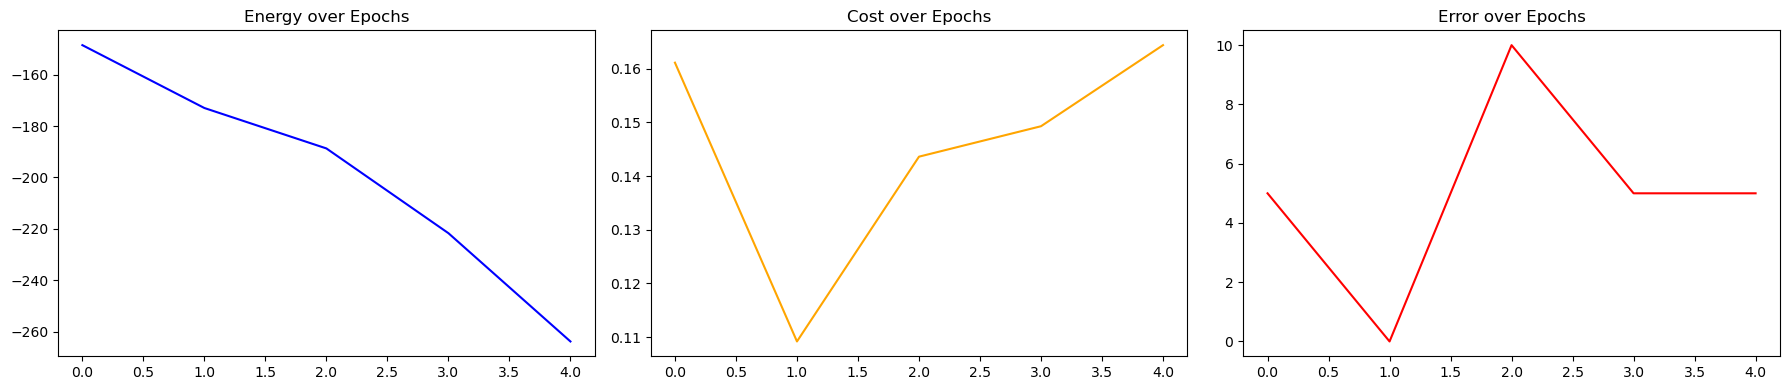

In [2]:
import os
import gzip
import pickle
import numpy as np
import torch
from urllib.request import urlretrieve
import matplotlib.pyplot as plt
from tqdm import tqdm
from model import Network
import networkx as nx


class ExternalWorld:
    def __init__(self):
        path = os.path.join(os.getcwd(), "mnist.pkl.gz")
        if not os.path.isfile(path):
            urlretrieve("http://www.iro.umontreal.ca/~lisa/deep/data/mnist/mnist.pkl.gz", path)
        with gzip.open(path, "rb") as f:
            train, valid, test = pickle.load(f, encoding="latin1")
        self.x = torch.tensor(np.vstack((train[0], valid[0], test[0])), dtype=torch.float32)
        self.y = torch.tensor(np.hstack((train[1], valid[1], test[1])), dtype=torch.int64)
        self.size_dataset = len(self.x)




mnist_net = Network("mnist", ExternalWorld(), {
    "hidden_sizes": [500],
    "n_epochs": 5,
    "batch_size": 20,
    "n_it_neg": 1,
    "n_it_pos": 1,
    "alphas": [np.float32(0.4), np.float32(0.1), np.float32(0.008)],
    "output_size": 10,
})
# Initialize and train
train_net(mnist_net)







In [15]:
def find_min_energy_state_for_digit(net, target_digit=6, n_iterations=10000):
    """
    Finds the minimum-energy input state that produces the target digit.
    Args:
        net: Trained Network instance
        target_digit: The desired digit output (0-9)
        n_iterations: Number of relaxation steps
    Returns:
        The optimized input tensor
    """
    input_size = net.external_world.x.shape[1]  # 784 for MNIST
    x_opt = torch.randn((1, input_size), dtype=torch.float32)  # Random initial input

    # Clamp the output layer to one-hot encoded target digit
    target_output = torch.zeros((1, 10))
    target_output[0, target_digit] = 100

    # Run relaxation with input free & output clamped
    net.negative_phase_clamp(n_iterations, clamped_nodes={len(net.layers) - 1: target_output})

    return net.layers[0].detach()  # Return the input layer producing minimum energy for target digit


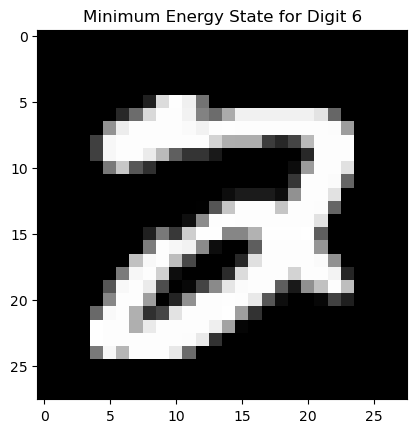

In [16]:
optimized_input = find_min_energy_state_for_digit(mnist_net, target_digit=3)

# Visualize the generated minimum-energy input for digit 6
import matplotlib.pyplot as plt
plt.imshow(optimized_input[0].view(28, 28).numpy(), cmap="gray")

plt.title("Minimum Energy State for Digit 6")
plt.show()
